In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import nheatmap
from time import time
from pathlib import Path
import re

from time import time

from stat_tools  import Benjamini_Hochberg



In [3]:
mpl.rcParams['figure.figsize'] = [4, 3]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.size'] = 8
mpl.rcParams['lines.linewidth'] = 1.
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [4]:
data_path = Path('../pcawg/pcawg_data1/')
data_path_broad = Path('../pcawg/broad/')

In [5]:
savefigs = True

# Load prostate tumor data from the PRAD-US project in PCAWG

Data source 1: https://dcc.icgc.org/releases/current/Projects/PRAD-CA

In [6]:
# The original data
# # start = time()
# df_expression = pd.read_table(data_path / 'exp_seq.PRAD-US.tsv.gz')
# print(time() - start)

# New broad TCGA firehose 
# data
df_expression = pd.read_table(data_path_broad / 'PRAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt', skiprows=[1])

df_expression['gene_id'] = df_expression.iloc[:,0].str.split('|').str[0]
df_expression.drop(columns="Hybridization REF", inplace=True)
df_expression = df_expression.loc[df_expression['gene_id'] != '?']

# Only one gene is duplicated. Drop it.
print("Duplicate genes:", df_expression.loc[df_expression['gene_id'].duplicated(), 'gene_id'])
df_expression = df_expression.loc[~df_expression['gene_id'].duplicated()]
df_expression.set_index('gene_id', inplace=True)

# Unstack
df_expression = df_expression.unstack().reset_index().rename(columns={'level_0':'sample', 0:'expression'})


# Add specimen and donor names and types
myre_donor = re.compile(r'TCGA-\w{2}-\w{4}')
myre_specimen = re.compile(r'TCGA-\w{2}-\w{4}-\w{3}')
df_expression['submitted_donor_id'] = df_expression['sample'].apply(lambda x: myre_donor.match(x)[0])
df_expression['submitted_specimen_id'] = df_expression['sample'].apply(lambda x: myre_specimen.match(x)[0])

# Normalize by counts per million
df_expression['tpm_read_count'] = df_expression.groupby('submitted_specimen_id')['expression'].transform(lambda x: 1e6*x/x.sum())
df_expression['log_tpm_read_count'] = np.log10(1+df_expression['tpm_read_count'])



Duplicate genes: 16301    SLC35E2
Name: gene_id, dtype: object


In [7]:
df_expression.head()

,sample,gene_id,expression,submitted_donor_id,submitted_specimen_id,tpm_read_count,log_tpm_read_count
0,TCGA-2A-A8VL-01A-21R-A37L-07,A1BG,67.9197,TCGA-2A-A8VL,TCGA-2A-A8VL-01A,3.306215,0.634096
1,TCGA-2A-A8VL-01A-21R-A37L-07,A1CF,0.0000,TCGA-2A-A8VL,TCGA-2A-A8VL-01A,0.000000,0.000000
2,TCGA-2A-A8VL-01A-21R-A37L-07,A2BP1,25.2317,TCGA-2A-A8VL,TCGA-2A-A8VL-01A,1.228236,0.347961
3,TCGA-2A-A8VL-01A-21R-A37L-07,A2LD1,136.0453,TCGA-2A-A8VL,TCGA-2A-A8VL-01A,6.622452,0.882095
4,TCGA-2A-A8VL-01A-21R-A37L-07,A2ML1,45.3141,TCGA-2A-A8VL,TCGA-2A-A8VL-01A,2.205813,0.505938


{'bodies': [<matplotlib.collections.PolyCollection at 0x32d6f6e50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1060ae990>,
 'cmins': <matplotlib.collections.LineCollection at 0x3d5f31e10>,
 'cbars': <matplotlib.collections.LineCollection at 0x3d5f333d0>}

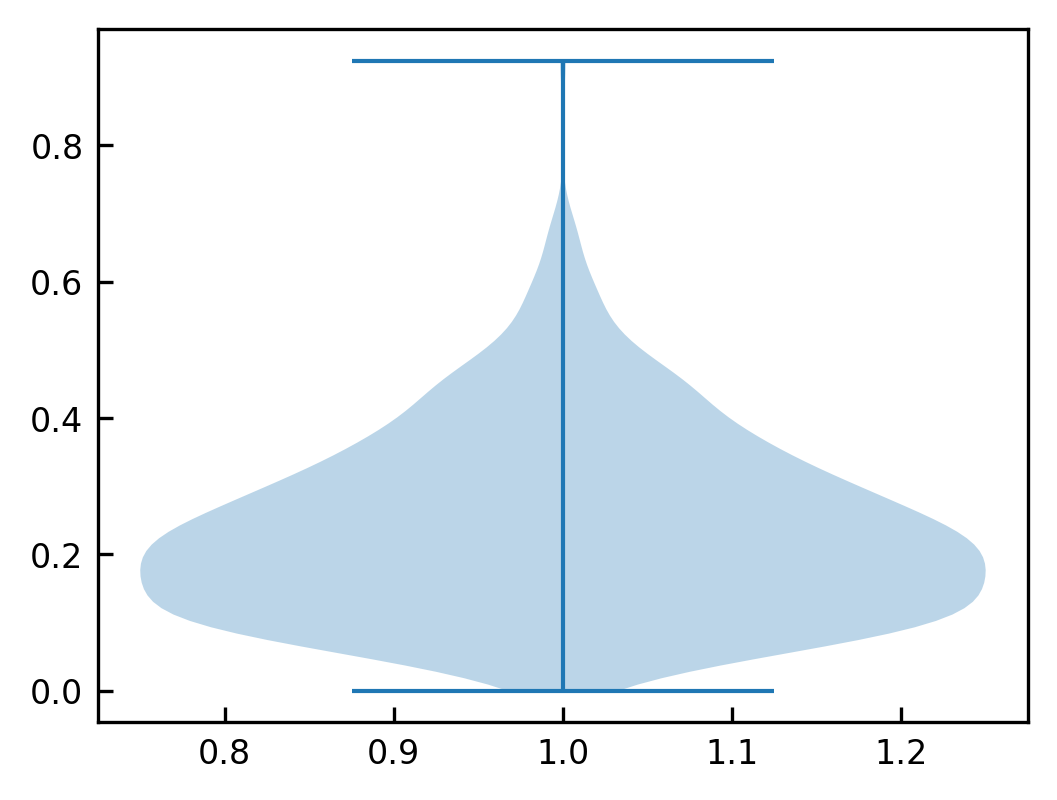

In [8]:
plt.violinplot(df_expression.loc[df_expression['gene_id']=='SIGLEC7', 'log_tpm_read_count'])

# Load the type of specimen: we want to compare tumor with normal-adjacent-to-tumor

In [9]:
df_specimen = pd.read_table(data_path / 'specimen.PRAD-US.tsv.gz')

# List types of specimens
df_specimen['specimen_type'].unique()

print("Number of donors", len(df_specimen['icgc_donor_id'].drop_duplicates()))

# No tumor stage information
df_specimen['tumour_stage'].unique()

Number of donors 500


array([nan])

In [10]:
# Merge specimen data with expressions

In [11]:
df_expression.iloc[0]

sample                   TCGA-2A-A8VL-01A-21R-A37L-07
gene_id                                          A1BG
expression                                    67.9197
submitted_donor_id                       TCGA-2A-A8VL
submitted_specimen_id                TCGA-2A-A8VL-01A
tpm_read_count                               3.306215
log_tpm_read_count                           0.634096
Name: 0, dtype: object

In [12]:
# Merge specimen data with expressions

df = pd.merge(df_expression,
         df_specimen[['submitted_specimen_id', 'specimen_type']],
         how='left',
         on='submitted_specimen_id')

df = df.loc[df['specimen_type'].isin(['Primary tumour - solid tissue',
       'Normal - tissue adjacent to primary'])]

# Only keep normal and primary tumor.

df['specimen_type'].unique()

array(['Primary tumour - solid tissue',
       'Normal - tissue adjacent to primary'], dtype=object)

### Load sialic acid genes

In [13]:
# In R
# Load 'TCGAdata.RData'
# 
# Run:
# > write.csv(unique(IMM$gene_name), file = 'immune_genes.csv', row.names = FALSE)
# > write.csv(unique(SIAL$gene_name), file = 'sialic_acid_genes.csv', row.names = FALSE)

In [14]:
all_genes = df['gene_id'].drop_duplicates().tolist()

In [15]:
immune_genes = pd.read_table('gene lists/immune_genes.csv')['x'].to_list()
sialic_genes = pd.read_table('gene lists/sialic_acid_genes.csv')['x'].to_list()
sialic_genes.remove('C20orf173')
print(len(immune_genes))

# Exclude immune genes that overlap. There are four
print((set(immune_genes).intersection(sialic_genes)))
print("Overlapping sialic and immune genes", len(set(immune_genes).intersection(sialic_genes)))
immune_genes = list(set(immune_genes).difference(sialic_genes))
print(len(immune_genes))
print(set(immune_genes).intersection(sialic_genes))
print(len(sialic_genes))

531
{'ST3GAL6', 'ST8SIA1', 'ST6GALNAC4', 'NPL'}
Overlapping sialic and immune genes 4
527
set()
33


In [16]:
# Let's look at distributions to justify our log scaling

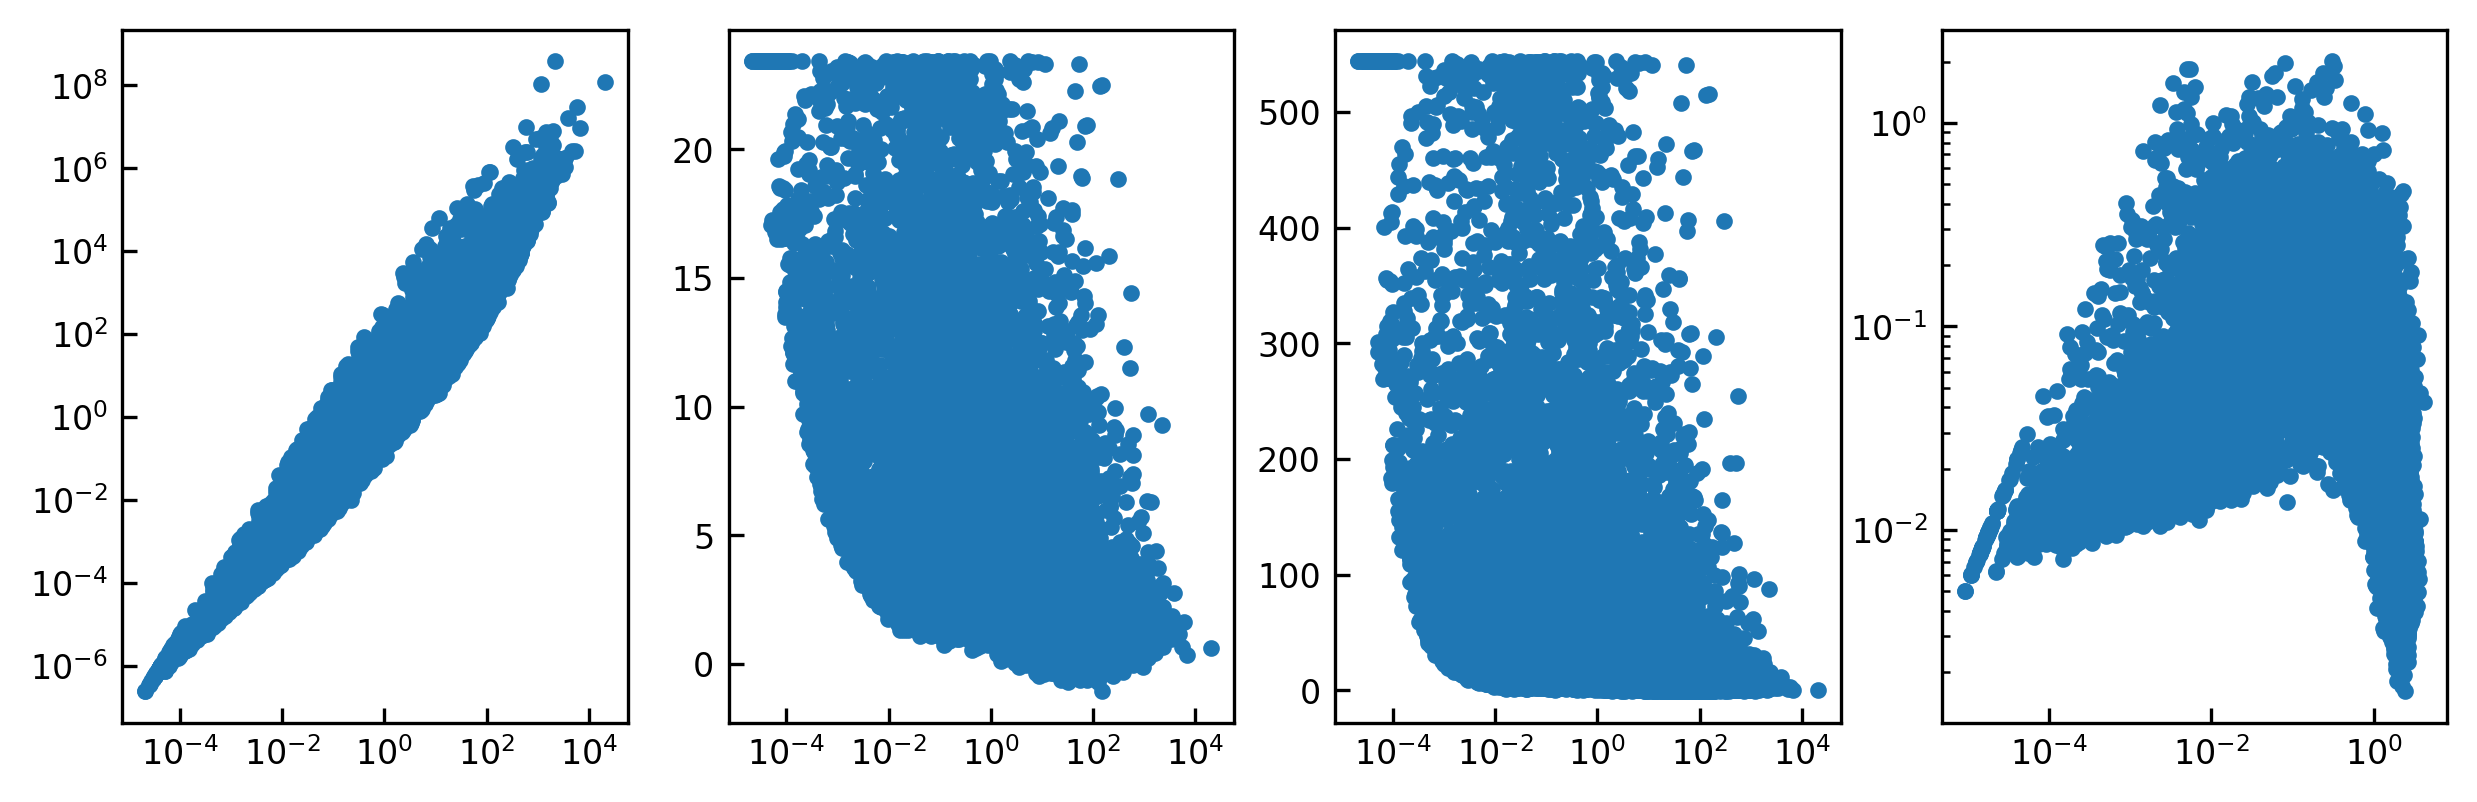

In [17]:
mean = df.groupby('gene_id')['tpm_read_count'].mean()
var = df.groupby('gene_id')['tpm_read_count'].var()
skew = df.groupby('gene_id')['tpm_read_count'].skew()
kurtosis = df.groupby('gene_id')['tpm_read_count'].apply(sp.stats.kurtosis)

mean_log = df.groupby('gene_id')['log_tpm_read_count'].mean()
var_log = df.groupby('gene_id')['log_tpm_read_count'].var()

figure, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].loglog(mean, var, '.')
ax[1].semilogx(mean, skew, '.')
ax[2].semilogx(mean, kurtosis, '.')
ax[3].loglog(mean_log, var_log/mean_log, '.')



## Make a violin plot: compare aggregate expression between cancer and normal


Number of primary tumor samples with SIGLEC7 : 497
Number of normal samples with SIGLEC7 : 52


<Axes: xlabel='gene_id', ylabel='log_tpm_read_count'>

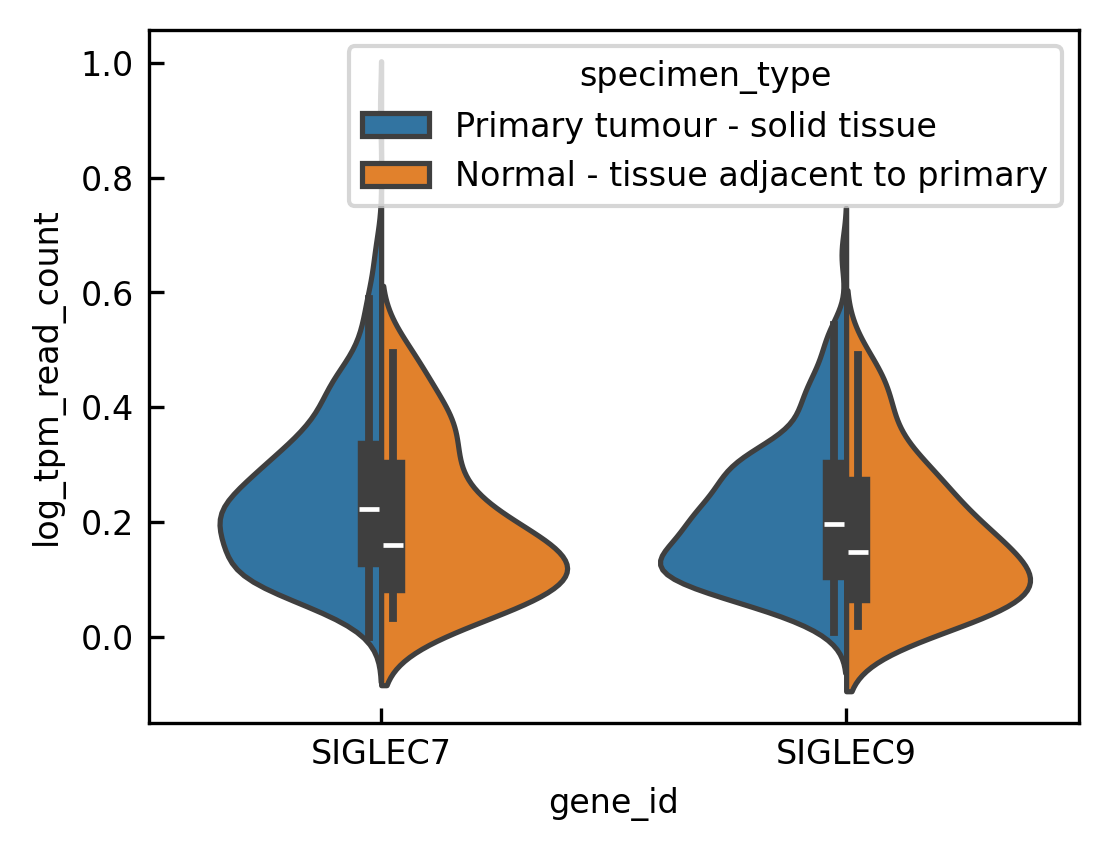

In [18]:
gene_list = ['SIGLEC7', 'SIGLEC9']
df_select_genes = df.loc[(df['gene_id'].isin(gene_list))
                                  & (df['specimen_type'].isin(
                                      ['Primary tumour - solid tissue', 'Normal - tissue adjacent to primary']))]
df_select_genes.head()

print("Number of primary tumor samples with SIGLEC7 :",
      len(df_select_genes.loc[(df_select_genes['gene_id']=='SIGLEC7')
                              & (df_select_genes['specimen_type']=='Primary tumour - solid tissue')]))
print("Number of normal samples with SIGLEC7 :",
      len(df_select_genes.loc[(df_select_genes['gene_id']=='SIGLEC7')
                              & (df_select_genes['specimen_type']=='Normal - tissue adjacent to primary')]))

sns.violinplot(data=df_select_genes, x='gene_id', y='log_tpm_read_count', hue='specimen_type', split=True)

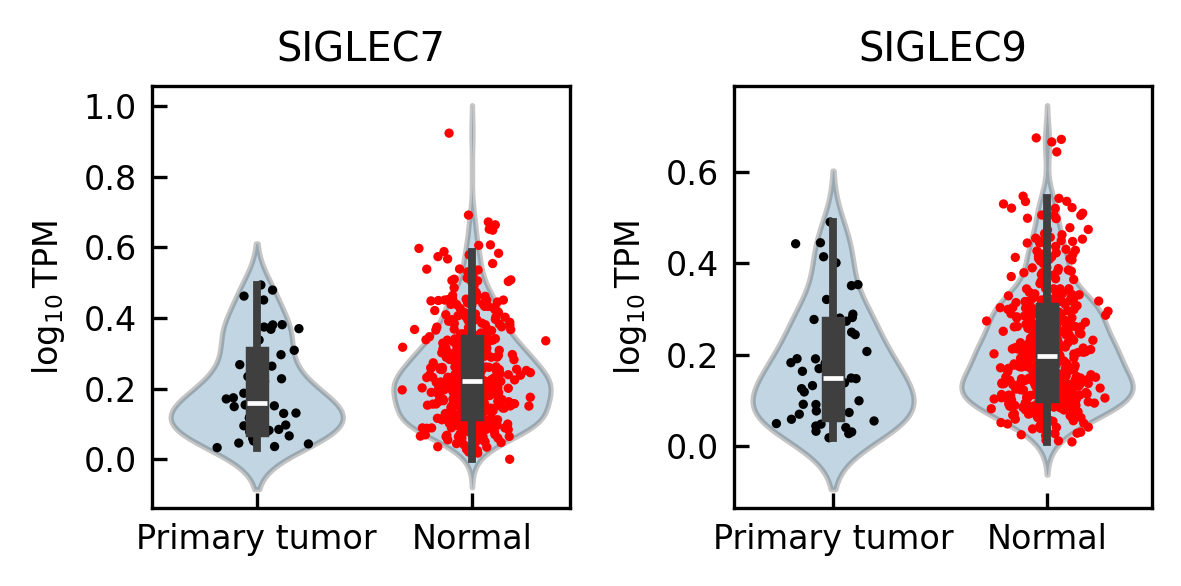

In [19]:
fig, ax = plt.subplots(1, len(gene_list), figsize=(len(gene_list)*2, 2))

for i, gene in enumerate(gene_list):
    sns.violinplot(data=df_select_genes.loc[df_select_genes['gene_id']==gene],
                   x='specimen_type',
                   y='log_tpm_read_count',
                   ax=ax[i],
                   alpha=0.3,
                   order=['Normal - tissue adjacent to primary', 'Primary tumour - solid tissue'])
    
    
    # Show individual dots and make violinplot transparent
    # Instead of using sns.stripplot, we can use plt.scatter
    
    for k, specimen_type in enumerate(['Normal - tissue adjacent to primary', 'Primary tumour - solid tissue']):

        y = df_select_genes.loc[(df_select_genes['gene_id']==gene) & (df_select_genes['specimen_type']==specimen_type), 'log_tpm_read_count']
        x = np.random.randn(len(y))*0.1 + k
        c = 'red' if specimen_type == 'Primary tumour - solid tissue' else 'black'
        ax[i].scatter(x, y, color=c, edgecolors='None', s=5)

    # jitter = np.random.randn(len(df_select_genes.loc[df_select_genes['gene_id']==gene]))
    # df_select_genes.loc[df_select_genes['gene_id']==gene, 'jitter'] = jitter
    # df_select_genes.loc[(df_select_genes['gene_id']==gene) & (df_select_genes['specimen_type']=='Primary tumour - solid tissue'), 'jitter'] += 1
    # plt.scatter(jitter_x+0, df_select_genes.loc[(df_select_genes['gene_id']==gene) & (df_select_genes['specimen_type']=='Primary tumour - solid tissue'), 'log_tpm_read_count'], color='black', alpha=0.3)
    # plt.scatter(data=df_select_genes.loc[df_select_genes['gene_id']==gene], x='jitter', y='log_tpm_read_count', color='black', alpha=0.3)
    # sns.stripplot(data=df_select_genes.loc[df_select_genes['gene_id']==gene], x='specimen_type', y='log_tpm_read_count', ax=ax[i], color='black')

    ax[i].set_title(gene)
    ax[i].set_ylabel('$\\log_{10}$TPM')
    ax[i].set_xlabel('')
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['Primary tumor', 'Normal'])

fig.tight_layout()
if savefigs:
    plt.savefig('figures/siglec_violin.png', dpi=300)




In [20]:

if savefigs:
    # Save all siglec data

    df_select_genes = df.loc[(df['gene_id'].str.startswith('SIGLEC'))
                                  & (df['specimen_type'].isin(
                                      ['Primary tumour - solid tissue', 'Normal - tissue adjacent to primary']))]
    print(df_select_genes['gene_id'].unique())

    df_select_genes[['submitted_specimen_id', 'gene_id', 'log_tpm_read_count', 'specimen_type']]\
            .to_csv('results/for_siglec_violin_plots.csv',
                    index=False)
    # Load with:
    # df_select_genes = pd.read_csv('results/for_siglec_violin_plots.csv')

    # Save all data
    df.to_csv('results/all_data.csv.zip', index=False)
    # Load with:
    # df = pd.read_csv('results/all_data.csv.zip')



['SIGLEC10' 'SIGLEC11' 'SIGLEC12' 'SIGLEC14' 'SIGLEC15' 'SIGLEC16'
 'SIGLEC1' 'SIGLEC5' 'SIGLEC6' 'SIGLEC7' 'SIGLEC8' 'SIGLEC9' 'SIGLECP3']


# Compare ratio of expression between matched cancer and normal adjacent tissue


In [21]:
gene_list = sialic_genes
df_select_genes = df.loc[(df['gene_id'].isin(gene_list))
                                  & (df['specimen_type'].isin(
                                      ['Primary tumour - solid tissue', 'Normal - tissue adjacent to primary']))]


In [22]:
df_cancer = df_select_genes[df_select_genes['specimen_type']=='Primary tumour - solid tissue']
df_normal = df_select_genes[df_select_genes['specimen_type']=='Normal - tissue adjacent to primary']

df_ratio = pd.merge(
    df_cancer,
    df_normal,
    on=['submitted_donor_id', 'gene_id'],
    how='inner',
    suffixes=('_cancer','_normal'))

# df_ratio['tpm_ratio'] = df_ratio['tpm_read_count_cancer']/df_ratio['tpm_read_count_normal']
df_ratio['tpm_ratio'] = df_ratio['log_tpm_read_count_cancer'] - df_ratio['log_tpm_read_count_normal']

print(len(df_ratio))

1716


In [23]:
len(df_ratio['submitted_donor_id'].drop_duplicates())

52

Text(0, 0.5, 'Occurrences')

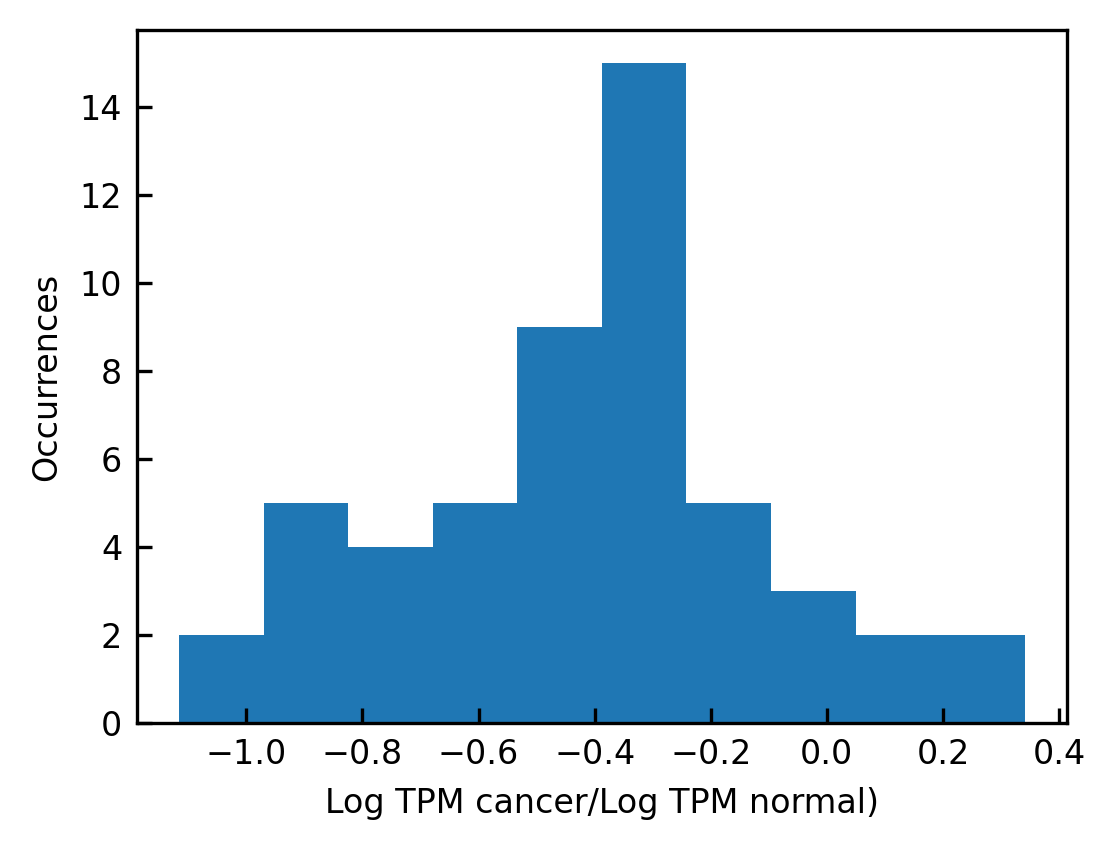

In [24]:
plt.hist(df_ratio.loc[df_ratio['gene_id']=="ST6GALNAC2", 'tpm_ratio'])
plt.xlabel('Log TPM cancer/Log TPM normal)')
plt.ylabel('Occurrences')

Text(0, 0.5, 'Occurrences')

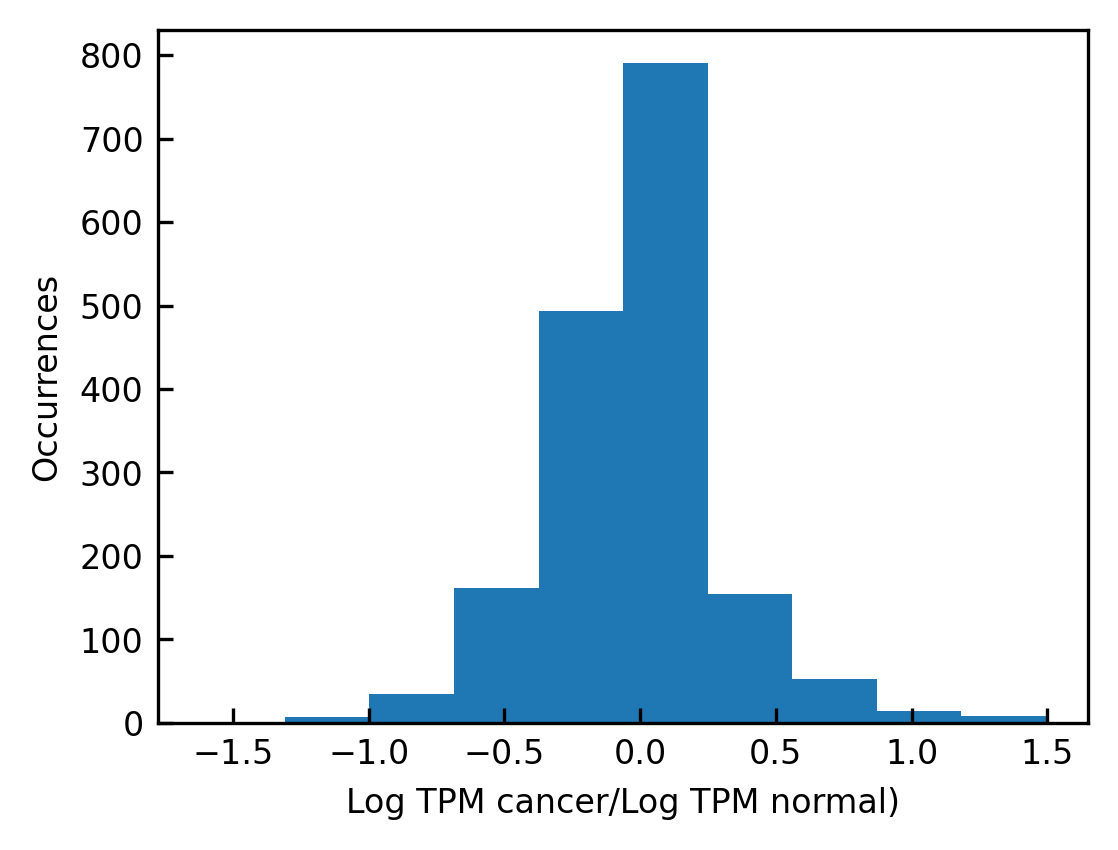

In [25]:
plt.hist(df_ratio['tpm_ratio'])
plt.xlabel('Log TPM cancer/Log TPM normal)')
plt.ylabel('Occurrences')

In [26]:
df_volcano = []
for gene, df_ in df_ratio.groupby('gene_id'):
    t, p = sp.stats.ttest_1samp(df_['tpm_ratio'],
                   0)
    df_volcano.append({'gene': gene, 't': t, 'p': p, 'log_fc': df_['tpm_ratio'].mean()})#, 'cluster': gene_to_cluster[gene]})
df_volcano = pd.DataFrame(df_volcano)
# df_volcano['cluster'] = df_volcano['cluster'].astype('category')

In [27]:
p_cutoff, _ = Benjamini_Hochberg(df_volcano['p'], alpha=0.1)
df_volcano['above_threshhold'] = df_volcano['p'] < p_cutoff

(-0.6, 0.6)

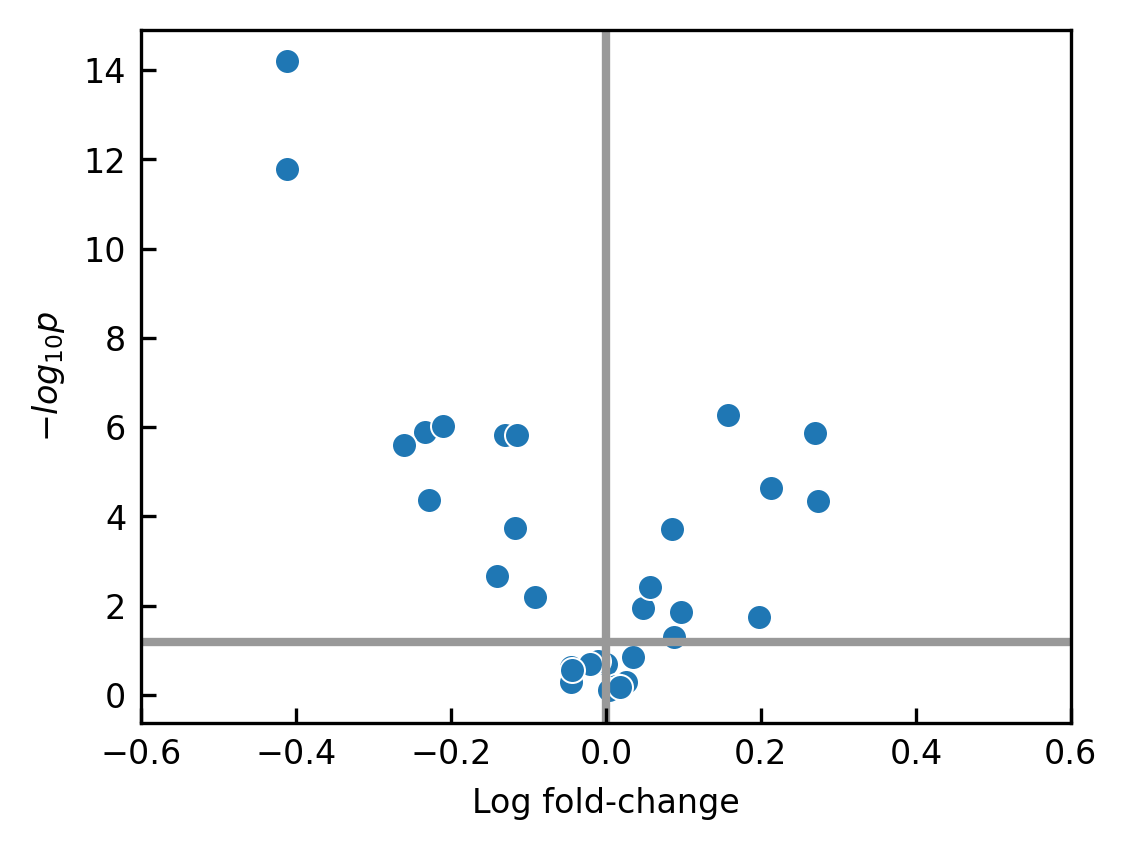

In [28]:

sns.scatterplot(x=df_volcano['log_fc'],
                y=-np.log10(df_volcano['p']),)
plt.axhline(-np.log10(p_cutoff), c='0.6', lw=2, zorder=1)
plt.axvline(0, c='0.6', lw=2, zorder=1)
plt.xlabel('Log fold-change')
plt.ylabel('$-log_{10} p$')
plt.xlim(-0.6, 0.6)

# Make heatmap of ratio of matches samples

In [29]:
df_volcano.loc[df_volcano['p']<p_cutoff,'gene']

0           CMAS
1           CTSA
2           GLB1
3            GNE
5           NANS
6           NEU1
8           NEU3
10           NPL
11       SLC17A5
13       ST3GAL1
14       ST3GAL2
16       ST3GAL4
17       ST3GAL5
19       ST6GAL1
20       ST6GAL2
21    ST6GALNAC1
22    ST6GALNAC2
23    ST6GALNAC3
24    ST6GALNAC4
26    ST6GALNAC6
27       ST8SIA1
Name: gene, dtype: object

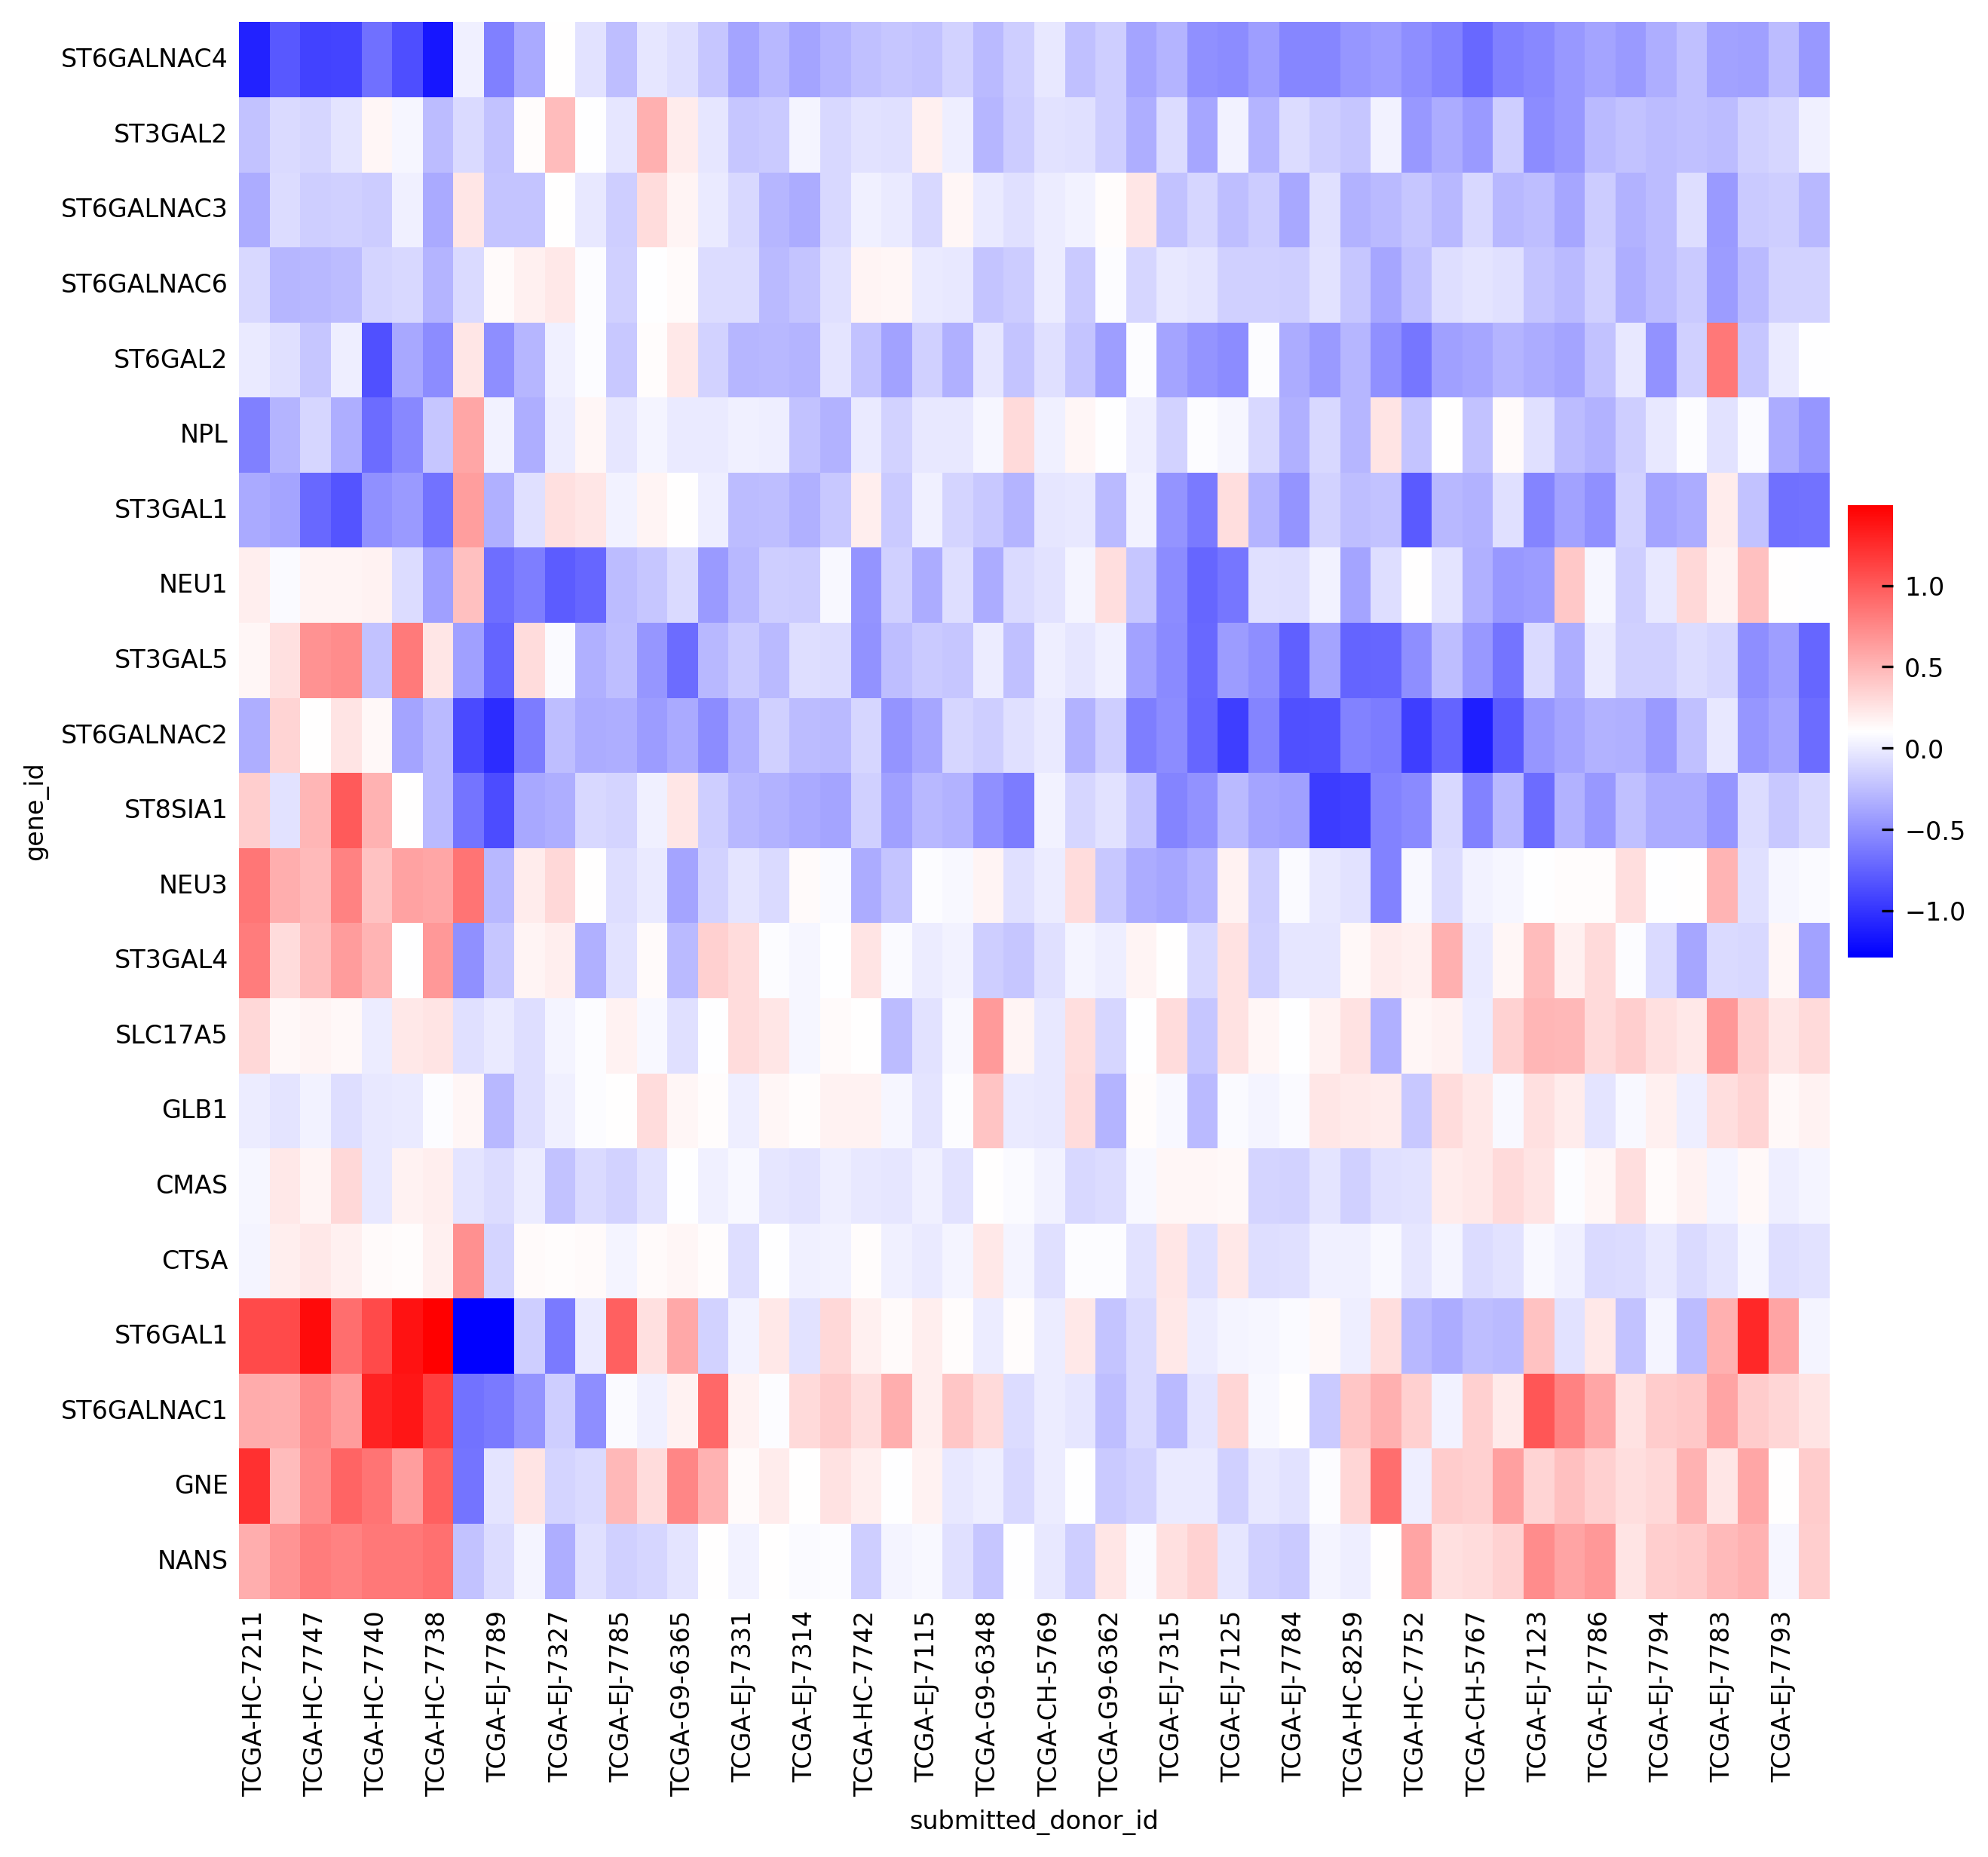

In [30]:
sig_genes = df_volcano.loc[df_volcano['p']<p_cutoff,'gene'].to_list()

g = sns.clustermap(pd.pivot_table(df_ratio.loc[df_ratio['gene_id'].isin(sig_genes)],
               values='tpm_ratio',
               columns='submitted_donor_id',
               index='gene_id'),
               cmap='bwr',
               z_score=None,
               cbar_pos=[0.9, 0.4, 0.02, 0.2],
               method='ward')

g.ax_heatmap.yaxis.set_label_position('left')
g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.tick_params(left=False, bottom=False, right=False, top=False)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
if savefigs:
    plt.savefig('patient_ratio_sialic_heatmap.png', dpi=600) 

In [31]:
sig_genes = df_volcano.loc[df_volcano['p']<p_cutoff,'gene'].to_list()
df_ = df.loc[(df['gene_id'].isin(sig_genes))
       &(df['submitted_donor_id'].isin(df_ratio['submitted_donor_id'].drop_duplicates()))]
pt_normal = pd.pivot_table(df_.loc[df_['specimen_type']=='Normal - tissue adjacent to primary'],
               values='log_tpm_read_count',
               columns='submitted_specimen_id',
               index='gene_id')
pt_cancer = pd.pivot_table(df_.loc[df_['specimen_type']=='Primary tumour - solid tissue'],
               values='log_tpm_read_count',
               columns='submitted_specimen_id',
               index='gene_id')
pt = pd.concat((pt_cancer,pt_normal),axis=1)


In [32]:
pt_normal.shape, pt_cancer.shape

((21, 52), (21, 52))

In [33]:
# g = sns.clustermap(pt,
#                cmap='bwr',
#                z_score='row',
#                cbar_pos=[0.9, 0.4, 0.02, 0.2],
#                method='ward',
#                col_cluster=False)

# g.ax_heatmap.yaxis.set_label_position('left')
# g.ax_heatmap.yaxis.tick_left()
# g.ax_heatmap.tick_params(left=False, bottom=False, right=False, top=False)
# g.ax_row_dendrogram.set_visible(False)
# g.ax_col_dendrogram.set_visible(False)
# # plt.savefig('patient_matched_sialic_heatmap.png', dpi=600)

In [34]:


# z_score = pt.loc[genes_clustered,
#                             specimen_clustered].T
# z_score = (z_score - z_score.mean()) / z_score.std()
# z_score[z_score<-3] = -3
# z_score[z_score>3] = 3
# cmaps ={'specimen_type':'Paired',}
# g = nheatmap.nhm(data=z_score.T,
#                  dfc=specimen_id_and_type.set_index('submitted_specimen_id'),
#                  figsize=(8, 4),
#                  linewidths=0,
#                  showyticks=True,
#                  cmapCenter='bwr')
# fig, plots = g.run()
